In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))

# 5.1) 중고나라 핸드폰 거래가격 예측하기

In [128]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# [Step1. 탐색적 분석] : 중고나라 데이터 분석

### [중고나라 데이터셋 살펴보기]

In [129]:
df = pd.read_csv("../data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
create_date      4951 non-null object
price            4951 non-null float64
text             4951 non-null object
phone_model      4951 non-null object
factory_price    4951 non-null int64
maker            4951 non-null object
price_index      4951 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.8+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


### [개별 피처 탐색하기]
##### date 피처 탐색

In [130]:
df['month'] = df['create_date'].apply(lambda x: x[:7])
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

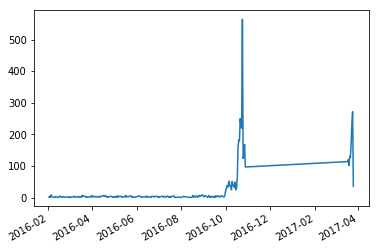

In [131]:
# 일별 거래 횟수를 계산하여 그래프로 출력
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

##### 가격 피처 탐색

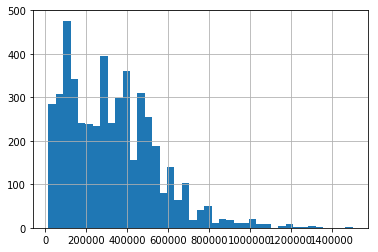

In [132]:
#가격의 분포를 그래프로 탐색
df['price'].hist(bins='auto')

In [133]:
#휴대폰 기종별 가격의 평균과 표준편차를 계산
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

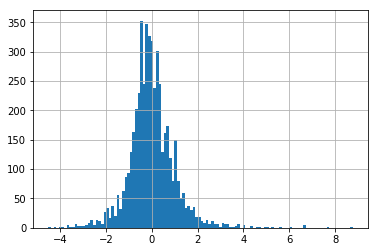

In [134]:
#이를 바탕으로 모든 데이터의 z-score를 계산. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게 한다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins='auto')

### 위 그래프로 동일 기종 내에서 price 피처의 분포는 정규분포에 가깝다는 것을 알 수 있다.
----
##### 출고가 피처 탐색

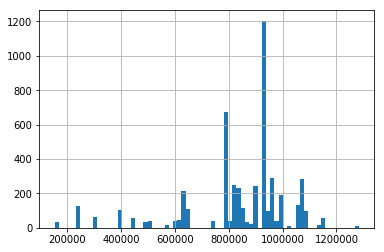

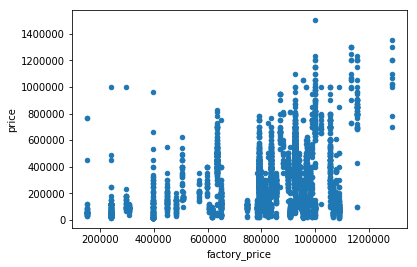

In [135]:
#출고가(factory_price) 피처의 분포를 탐색
df['factory_price'].hist(bins='auto')
#factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴보자.
df.plot.scatter(x='factory_price', y='price')

### 위 그래프 결과, 두 피처는 양의 상관 관계를 가지고 있음 이를 통해 factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미칠 것이라고 추정 가능.
----
##### 핸드폰 모델 피처 탐색

In [136]:
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x2b1f53db940>],
 'caps': [<matplotlib.lines.Line2D at 0x2b1f53e2390>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b1f53e6048>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2b1f53e2be0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2b1f53dba90>,
  <matplotlib.lines.Line2D at 0x2b1f53dbf28>]}

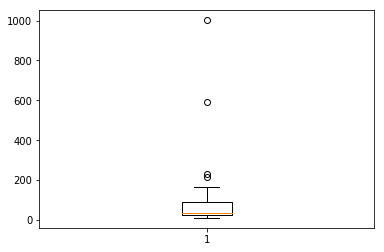

In [137]:
plt.boxplot(model_counts)

### 실행 결과, 휴대폰 기종의 개수는 총 64개이고 상위 5개의 기종을 제외하면 대부분 10~90개 사이의 데이터를 가지고 있다.

### `[미니 퀴즈 - 5.1]`
- `'maker', 'price_index' 피처에 대한 특징을 탐색해 보도록 합시다.` 
    - value_counts를 이용하여 피처의 분포를 탐색해보도록 합시다.

In [138]:
maker_counts = df['maker'].value_counts()
maker_counts

apple      2450
samsung    1642
lg          677
pantech      57
sony         37
huawei       35
tg           28
sky          25
Name: maker, dtype: int64

{'boxes': [<matplotlib.lines.Line2D at 0x2b1f5423668>],
 'caps': [<matplotlib.lines.Line2D at 0x2b1f542a0b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b1f542ad30>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2b1f542a908>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2b1f54237b8>,
  <matplotlib.lines.Line2D at 0x2b1f5423c50>]}

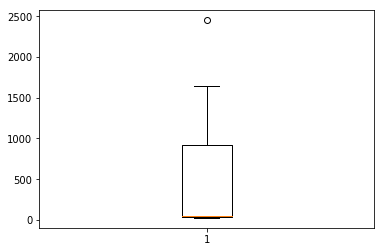

In [139]:
plt.boxplot(maker_counts)

103.05    3061
95.96     1311
102.59     448
94.90      131
Name: price_index, dtype: int64


{'boxes': [<matplotlib.lines.Line2D at 0x2b1f546b550>],
 'caps': [<matplotlib.lines.Line2D at 0x2b1f546bf60>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b1f5474c18>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2b1f54747f0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2b1f546b6a0>,
  <matplotlib.lines.Line2D at 0x2b1f546bb38>]}

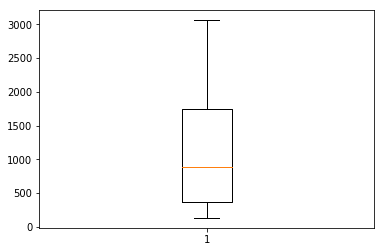

In [140]:
price_index_counts = df['price_index'].value_counts()
print(price_index_counts)
plt.boxplot(price_index_counts)

### 실행 결과, maker의 경우 3개의 maker가 대부분의 데이터를 대표하고 있다. 
### price_index(물가 변동률)는 매달마다 일어나지 않는다는 것을 알 수 있다.

----
### [Random forest regressor를 이용한 가격 예측]

In [141]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,month
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,2017-03
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2016-10
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,2016-10
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,2017-03
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,2016-04


##### Random forest 모델 학습

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 데이터를 학습/테스트용 데이터로 분리
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델 학습
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델 평가
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 10629268336.952, test: 13855536752.991
R^2 train: 0.781, test: 0.683


### 실행 결과, Train score와 Test score의 차이가 심한 것을 볼 때, 이는 과적합이 일어났다고 할 수 있다.
##### 피처 중요도 분석

<Container object of 84 artists>

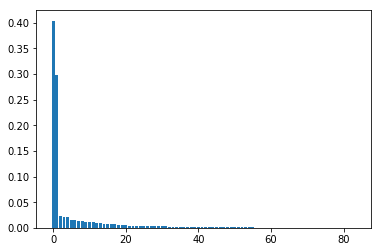

In [143]:
# 학습한 모델의 피처 중요도를 그래프로 살펴보자.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

In [144]:
#학습한 모델의 피처 중요도 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key = lambda tup: tup[1], reverse = True)[:10]

[('factory_price', 0.40418332917808675),
 ('maker_apple', 0.2979193311614067),
 ('phone_model_galaxy s3 3g 8gb', 0.02207153017431931),
 ('phone_model_iphone se 64gb', 0.021311014614534354),
 ('price_index', 0.020850535086043512),
 ('phone_model_galaxy s4 32gb', 0.015620095291590839),
 ('month_2017-03', 0.01456541104154635),
 ('maker_samsung', 0.013765609081450773),
 ('phone_model_galaxy s6 32gb', 0.01242236483319837),
 ('month_2016-05', 0.010879591637254896)]

### 이를 통해 factory_price, maker_apple... 순으로 모델에 중요한 피처라는 것을 알 수 있다.

In [145]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]: 
        print(sorted_feature)

('month_2017-03', 0.01456541104154635)
('month_2016-05', 0.010879591637254896)
('month_2016-09', 0.008350243680816119)
('month_2016-04', 0.0074625864201540255)
('month_2016-10', 0.006428576576672979)
('month_2016-06', 0.00441888093018058)
('month_2016-08', 0.0036891927690665036)
('month_2016-07', 0.0027112583805513233)
('month_2016-03', 0.0023879235984999147)
('month_2016-02', 0.0011008709085288714)


### 실행 결과, 최근에 가까운 month일수록 피처의 중요도가 높은 것을 알 수 있다.

##### 예측 결과 scatter plot

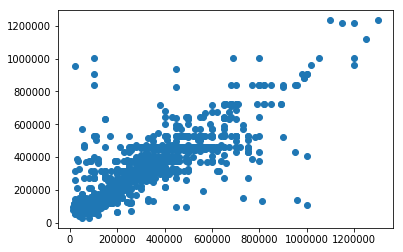

In [146]:
plt.scatter(y_test.values, y_test_pred)

----
# [Step2. 피처 엔지니어링] : 예측 모델 개선

### [기존 feature의 가공]
### create_data 피처를 분석에 활용하기 위해 '시간 점수'라는 것을 만든다.
    1. create_data를 unixtime으로 변환한다. unixtime은 시간을 정수로 표현한 것이며, 값이 클수록 '최근'에 가까워진다.
    2. min-max 스케일링을 적용하여 unixtime을 상대적인 점수로 계산한다.
    3. 점수가 1에 가까울수록 최근에 작성한 게시물을 의미하며, 0에 가까울수록 오래된 게시물을 의미한다.
   ##### create_date로 시간점수 생성하기

In [147]:
# 데이터를 다시 불러온다.
df = pd.read_csv("../data/used_mobile_phone.csv")

In [148]:
from datetime import datetime
import time

# date를 unixtime으로 변환하는 함수를 정의
# mktime() = 시간의 부동 소수점을 나타내는 데 사용 시간 (초)을 돌려줍니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

In [149]:
#create_date 피처를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성한다. 먼저, unixtime으로 데이터를 변환
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))

In [150]:
#변환된 unixtime에 min-max스케일링을 적용한다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


##### phone_model 피처 분리
#### phone_model 피처는 '제품명 + 용량'으로 구성되어 있기 때문에 이를 나누어주기만 하면 2개의 분리된 피처를 얻을 수 있다.

In [151]:
df['phone_model'].head()

0          iphone 6 64gb
1    galaxy s6 edge 32gb
2         galaxy s6 32gb
3             lg g5 32gb
4              lg u 32gb
Name: phone_model, dtype: object

In [152]:
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

In [153]:
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))

In [154]:
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'boxes': [<matplotlib.lines.Line2D at 0x2b1fe6aeda0>,
 'caps': [<matplotlib.lines.Line2D at 0x2b1fe6b67f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b1fe6c04a8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2b1fe6c0080>,
 'whiskers': [<matplotlib.lines.Line2D at 0x2b1fe6aeef0>,
  <matplotlib.lines.Line2D at 0x2b1fe6c9160>]}

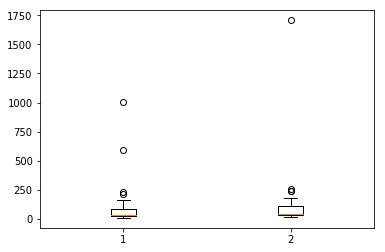

In [155]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처간의 기종별 거래 데이터 개수를 비교
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

In [156]:
# 기종명 + 용량으로 출고가를 찾기 위한 딕셔너리를 생성
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{('iphone 6', '64gb'): 924000, ('galaxy  ...


### 실행 결과, 쏠림 현상이 심해진 하나의 기종을 제외하면 전체적인 분포가 안정적으로 변한 것을 알 수 있다.
### 이는 phone_model 피처를 분리함으로써 얻을 수 있는 효과이다.

----
### [감성분석으로 물품의 상태 분류하기]
### 이번에는 텍스트 정보에 대한 피처 엔지니어링 수행. 텍스트 정보에는 물품의 상태가 나타나 있을 것이고 이는 가격 예측에 영향을 미칠 것이다. 따라서 물품의 상태를 분류할 수 있는 감성 분류가 필요하다.
    *활용방법*
    1. price 피처를 같은 기종 내에서의 z-score로 변환한다.
    2. z-score 기준, 상위 5%에 속하는 가격의 게시글은 '상태가 좋음', 하위 5%는 '상태가 나쁨' 그리고 그 외는 '보통'으로 판단한다. 상위 n% 판단은 quantile()함수를 사용한다.
    3. 정의한 세 가지 상태를 감성 분류의 정답 데이터로 사용한다.

##### 감성분류의 정답 데이터셋 생성

In [157]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,create_unixtime,create_time_score,phone_model_storage,phone_model_detail
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,1.489849e+09,0.985612,64gb,iphone 6
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,1.477408e+09,0.640288,32gb,galaxy s6 edge
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,1.477321e+09,0.637890,32gb,galaxy s6
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,1.490195e+09,0.995204,32gb,lg g5
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,1.460300e+09,0.165468,32gb,lg u


-1.3966616903783426
1.666982156397844


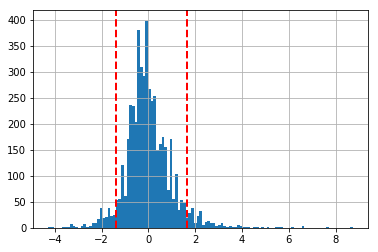

In [158]:
#거래 가격(price)의 z-score를 계산한다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게 한다.
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x-x.mean())/x.std())

#거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력
ax = df['price_by_group'].hist(bins='auto')

#z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound라고 저장
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

print(lower_bound)
print(upper_bound)

##### 감성 분류로 물품의 상태 분류하기

In [159]:
#lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

In [160]:
#분류
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))

df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


----
##### 텍스트 전처리

In [161]:
import pickle
import re

In [162]:
# 중고나라 불용어 사전을 불러온다.
with open('../data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

# 불용어 사전에 등록된 단어 10개를 출력
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


##### 형태소 단위로 추출
#### text_cleaning() 정의 후 전처리
    1. 텍스트에서 특수문자를 제거. 단, '+'와 ',' 문자는 제거하지 않는다
    2. 텍스트에서 숫자를 제거한다.

In [163]:
from konlpy.tag import Okt
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [164]:
# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수 stopword = 불용어
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

In [165]:
# 위 함수들을 적용한 형태소 추출 테스트
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


##### 빈출 형태소 2500개 선정

In [166]:
from collections import Counter

#get_pos()함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(),[])

In [167]:
corpus

['+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '리퍼',
 '기간',
 '만료',
 '되어서',
 '징',
 '하게',
 '되었습니다',
 '상태',
 '초',
 'a',
 '급',
 '스',
 '없습니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '+',
 '애플',
 '라이트',
 '팝니다',
 '리퍼',
 '기간',
 '만료',
 '되어서',
 '징',
 '하게',
 '되었습니다',
 '상태',
 '초',
 'a',
 '급',
 '스',
 '없습니다',
 '징',
 '애플',
 '라이트',
 '홈',
 '버튼',
 '링',
 '카메라',
 '링',
 '볼륨',
 '버튼',
 '슬립',
 '버튼',
 '검금',
 '심플',
 '튀지',
 '않게',
 '이쁘게',
 '했구요',
 '유심',
 '꽂고',
 '바로',
 '사용',
 '하시면',
 '됩니다',
 '사람',
 '이냐',
 '자주',
 '물어보고',
 '실제',
 '더욱',
 '이쁩니다',
 '밤',
 '영롱하게',
 '맥북',
 '뒷',
 '사과',
 '로고',
 '비춰지고',
 '요전',
 '넘어가기',
 '위해',
 '합니다',
 '가능합니다',
 '박스',
 '어머니',
 '버리시고',
 '이어폰',
 '충전기',
 '정품',
 '드립니다',
 '직거래',
 '우선',
 '순',
 '위로',
 '정',
 '싶으시면',
 '선',
 '입금',
 '택배',
 '발송',
 '해드리겠습니다',
 '믿으시면',
 '직거래',
 '하시길',
 '추천',
 '해요',
 '안전',
 '합니다',
 '서울시',
 '강남구',
 '역삼동',
 '차병원',
 '사거리',
 '근처',
 '가격',
 's',
 '팝니다',
 '직거래',
 's',
 '품명',
 's',
 '제품',
 '상태',
 '사진',
 '참고',
 '용량',
 '선택',
 '약정',
 '여부',
 '가능',
 '요금',

In [168]:
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

### 이는 추출한 형태소에서 가장 빈도수가 높은 형태소 2,500개를 선정한 것이다. 2,500개로 단어를 제한하는 이유는 텍스트 데이터의 피처를 제한하기 위함이다.만약 이를 제한하지 않으면 텍스트 데이터의 피처는 몇 만개, 혹은 몇 백만 개로 늘어날 수 있기 때문이다.

----
### 이제 전처리가 완료된 텍스트 데이터를 학습 데이터셋의 형태로 변환한다. 
    피처를 변환하는 방식은 TF-IDF를 사용하였으며, 아래 코드에서는 클래스 불균형을 맞춰주기 위해 부정 데이터 : 중립 데이터 : 긍정 데이터를 1:3:1의 비율로 데이터를 추출하였다. 일반적으로는 1:1:1의 비율로 데이터를 추출하지만 예제에서는 부정 데이터와 긍정 데이터의 양이 많지 않기 때문에 중립 데이터의 비중을 늘려주었다.
##### TF-IDF 벡터 생성

In [169]:
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

In [171]:
#1:3:1의 비율로 랜덤 샘플링을 수행
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

#샘플링 완료된 데이터셋을 정의
df_sample = negative_random.append(neutral_random).append(positive_random)
df_sample.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,create_unixtime,create_time_score,phone_model_storage,phone_model_detail,price_by_group,price_lower,price_upper,price_level
72,2017-03-17 12 18 00 PM,20000.0,판매완료 skt 갤럭시 노트 기가 부품용 만원에 가져가세요 직접거래,galaxy note3 32gb,1067000,samsung,95.96,1.489676e+09,0.980815,32gb,galaxy note3,-2.734338,57000.0,220000.0,0
177,2016-04-14 9 52 00 PM,40000.0,노트 브론즈골드 미들프레임 및 뷰커버 정품 일괄로 판매합니다 서비스 센터 신품 교...,galaxy note4 32gb,957000,samsung,102.59,1.460560e+09,0.172662,32gb,galaxy note4,-1.135445,40000.0,330000.0,0
666,2017-03-19 10 55 00 PM,90000.0,아이폰s 기가 실버 판매합니다 iphone s gb silver 택포 만원 아이...,iphone 5s 16gb,814000,apple,95.96,1.489849e+09,0.985612,16gb,iphone 5s,-1.524263,120000.0,347500.0,0
141,2016-07-09 11 50 00 AM,40000.0,"부품용 가격인하 g, g cat 액정 스크린 개 팔아요 깨진거아님 ...",g3 cat.6 32gb,649000,lg,102.59,1.467990e+09,0.378897,32gb,g3 cat.6,-0.837799,40000.0,150000.0,0
133,2016-07-09 3 29 00 AM,40000.0,"부품용 가격인하 g, g cat 액정 스크린 개 팔아요 깨진거아님 ...",g3 cat.6 32gb,649000,lg,102.59,1.467990e+09,0.378897,32gb,g3 cat.6,-0.837799,40000.0,150000.0,0


In [172]:
#TF-IDF를 수행하여 피처를 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [173]:
#감성 분류를 위한 학습 데이터셋을 정의
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


### 실행 결과, 학습 데이터셋은 1,284개, 테스트 데이터셋은 321개가 생성되었고 형태소를 표현하는 피처는 2,476개가 생성되었다.

----
##### 상품 상태 분류하기 
#### SVC => https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-7-%EC%BB%A4%EB%84%90-%EC%84%9C%ED%8F%AC%ED%8A%B8-%EB%B2%A1%ED%84%B0-%EB%A8%B8%EC%8B%A0/

In [174]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#SVD = Support Vector Machine, rbf = Radial Basis Function (RBF) kernel
#비선형 SVM 분류 모델을 학습하고 평가한다.
svm = SVC(kernel ='rbf', C=10.0, random_state =0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

Accuracy: 0.77


In [175]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


### 위 코드는 TF-IDF 피처 변환이 완료된 데이터셋으로 분류 모델을 학습한 것. 분류 모델은 SVM이라는 모델 사용
### 실행 결과, 약 0.8 정도의 정확도로 학습됨. Confusion Matrix를 보면 꽤나 정확하게 분류 모델이 학습되었음을 알 수 있다.

----
# [Step3. 예측] : 중고폰 거래가 예측
### [Random forest regressor 재학습]

In [176]:
# text 피처로부터 '상품 상태 피처(product_status)'를 생성
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

In [177]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,create_unixtime,create_time_score,phone_model_storage,phone_model_detail,price_by_group,price_lower,price_upper,price_level,product_status
0,2017-03-19 4 35 00 PM,550000.0,아이폰플러스 블랙+애플라이트 기가 팝니다 아이폰플러스 블랙+애플라이트 기가 팝니다...,iphone 6 64gb,924000,apple,95.96,1.489849e+09,0.985612,64gb,iphone 6,0.910563,180000.0,680000.0,1,1
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s엣지 기가 팝니다 직거래 갤럭시s엣지 기가 품명 갤럭시s엣지제품 단품상태 ...,galaxy s6 edge 32gb,979000,samsung,103.05,1.477408e+09,0.640288,32gb,galaxy s6 edge,1.003699,180000.0,414000.0,1,1
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s 풀박스로 팝니다 새상품급 실기스조차 없어요 직접거래 구매한지 개월만에 ...,galaxy s6 32gb,854000,samsung,103.05,1.477321e+09,0.637890,32gb,galaxy s6,0.669017,150000.0,349000.0,1,1
3,2017-03-23 11 14 00 PM,290000.0,sk g 티탄 폰 단품판매합니다 직접거래 sk g 티탄 폰 단품판매합니다 올 월...,lg g5 32gb,836000,lg,95.96,1.490195e+09,0.995204,32gb,lg g5,-0.330426,100000.0,500000.0,1,0
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c ultra e gb 미사용 새제품 팝니다 소니 엑스페리...,lg u 32gb,396000,lg,102.59,1.460300e+09,0.165468,32gb,lg u,1.014392,18000.0,400000.0,1,1


In [178]:
# 랜덤 포레스트 모델 학습을 위한 데이터 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
                'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# 학습/테스트 데이터를 분리
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [179]:
#랜덤 포레스트 모델을 학습하고 평가한다.
forest = RandomForestRegressor(n_estimators = 1000, criterion = 'mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 4767534949.343, test: 11065879467.824
R^2 train: 0.902, test: 0.747


[('factory_price', 0.25290546944144954),
 ('maker_apple', 0.25268334772742623),
 ('create_time_score', 0.11663746636296769),
 ('phone_model_storage_16gb', 0.06058715990741452),
 ('product_status_2', 0.046590386721666856),
 ('phone_model_detail_galaxy s7 edge', 0.02887550107881669),
 ('phone_model_storage_64gb', 0.026731836498208667),
 ('phone_model_detail_galaxy note5', 0.024717946082155634),
 ('phone_model_detail_galaxy s7', 0.022846327791739666),
 ('product_status_0', 0.021547543503452896)]

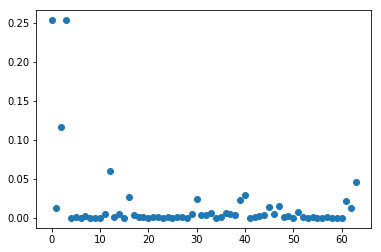

In [180]:
#피처 중요도 plot 출력
importances = forest.feature_importances_
plt.plot(importances, 'o')

#피처 중요도 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

### 이는 새로운 피처로 예측 모델을 다시 학습한 결과이다. 이를 통해 Train R2 score, Test R2 score 등의 지표가 매우 상승하였음을 확인할 수 있지만 여전히 과적합이 발생하고 있다는 것 또한 확인할 수 있다.
### 피처 중요도를 다시 분석한 결과, 영향력이 높은 피처 중 create_time_score, product_status가 있다는 것을 확인할 수 있다. 이는 새로운 피처가 중요한 역할을 수행하고 있다는 것이다.

In [181]:
from sklearn.externals import joblib

#프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리 
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


##### 예측 결과 scatter plot

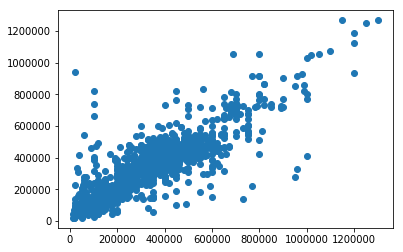

In [182]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴보자.
plt.scatter(y_test.values, y_test_pred)

----
### [최적의 모델 파라미터 찾기]


    모델을 학습할 때는 파라미터를 어떻게 설정하느냐에 따라 예측의 성능이 달라질 수 있다. 랜덤 포레스트의 경우, n_estimators와 max_depth라는 파라미터를 잘 설정하는 것이 중요하다. 이러한 최적의 파라미터는 반복적인 시도와 검증으로 찾아내야 한다.
    반복적인 실행으로 최적의 파라미터를 찾아내는 방법 중 하나가 Greedy Randomized Search라는 방법이다.
    다음의 코드는 이 방법을 실행하는 코드이다. 파라미터의 후보군을 정하고 RandomizedSearchCV 클래스가 실행할 random_grid를 지정해주기만 하면 된다.

In [183]:
from sklearn.model_selection import RandomizedSearchCV

#Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

In [184]:
#RandomizedSearchCV 오브젝트를 생성하여 모델을 정의
random_grid = {'n_estimators':n_estimators, 'max_features':max_features,
              'max_depth':max_depth, 'bootstrap':bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

In [185]:
# RandomizedSearchCV 모델을 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 36.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

----
##### 최적 파라미터 출력 - Greedy Randomzed Search를 실행하여 찾아낸 최적의 파라미터.

In [186]:
#앞서  선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력 - 이 파라미터로 모델을 학습할 때, 가장 좋은 성능
optimal_forest.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2000}

##### 최적 모델 학습 결과

In [187]:
# 최적의 파라미터를 적용한 모델로 중고폰의 가격을 예측하고 평가합니다.
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 8808357205.828, test: 7645657179.803
R^2 train: 0.818, test: 0.825


[('factory_price', 0.29654039856069353),
 ('maker_apple', 0.2756146356238213),
 ('phone_model_storage_16gb', 0.07214357742935129),
 ('create_time_score', 0.065731701234165),
 ('product_status_2', 0.06264327742602661),
 ('phone_model_detail_galaxy s7 edge', 0.027077101130705796),
 ('phone_model_detail_iphone 6', 0.02502060786681972),
 ('product_status_0', 0.024567712933748535),
 ('phone_model_detail_galaxy s4', 0.020530253111285535),
 ('product_status_1', 0.01367456581201699)]

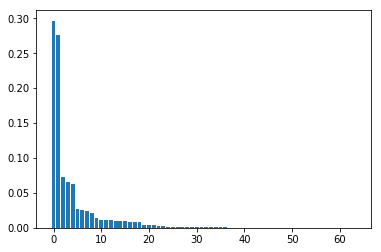

In [188]:
# 가격 예측 모델의 피처 중요도 plot을 출력
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

### 실행 결과, Train score는 다소 감소하였지만, Test score와의 차이가 현저하게 좁혀진 것을 볼 수 있다. 과적합 문제 해결.

##### 예측 결과 scatter plot

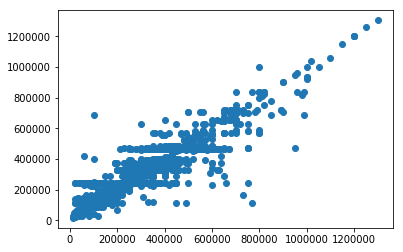

In [189]:
# 테스트 데이터의 y값과, 예측된 y값을 scatter plot을 활용하여 상관관계를 살펴보자.
plt.scatter(y_test.values, y_test_pred)

----
# [Step4. 프로토타입] : 얼마고(Almhago?)
    지금까지 완성한 중고 휴대폰 가격 예측 모델을 프로그램의 형태로 만들자. 
    프로그램 '얼마고(Almhago?)는 미리 학습한 모델과 피처로 중고 휴대폰의 가격을 예측한다.
    하지만 프로그램을 실행할 때마다 모델을 학습할 수는 없다. 따라서 다음에 다룰 코드를 통해 모델과 피처 정보를 파일 형태로 미리 저장해야 한다.
    model_to_factory_price_dict : 모델명, 용량으로 factory_price를 찾을 수 있는 파이썬 딕셔너리
    col_to_index_dict : 데이터 프레임의 피처를 번호로 표현한 파이썬 딕셔너리
    common_words : 가장 많이 등장하는 형태소 2,500개의 정보
    index_vectorizer, tfidf_vectorizer : 텍스트 정보를 TF-IDF 피처로 변환해주는 vectorizer
    svm : 텍스트 정보를 바탕으로 물품의 상태를 판별해주는 분류 모델(svm 분류 모델)
    optimal_forest : 최적의 파라미터로 학습한 가격 예측 모델
    
### [재사용을 위한 파일 저장]

In [190]:
# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장
with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, '../data/used_mobile_pickles/rf_regressor.pickle', compress = 1)

['../data/used_mobile_pickles/rf_regressor.pickle']

----
### [가격 예측 프로그램 만들기]
##### 예측에 필요한 파일 로드

In [191]:
import pickle

with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('../data/used_mobile_pickles/rf_regressor.pickle')

##### 프로그램(클래스) 만들기

In [192]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

-----
##### 프로그램 테스트

In [194]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 두 개(price_index, create_time_score)의 피처 정의
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글 입력
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트 생성
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)
# print(program_test_dict)
# 입력한 데이터로 판매 가격 예측
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 152307 원 입니다.


In [202]:
# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글 입력
program_test_dict1 = {"maker": "samsung",
                     "phone_model_detail": "galaxy s6",
                     "phone_model_storage": "32gb",
                     "text": '갤럭시s 풀박스로 팝니다 새상품급 실기스조차 없어요 직접거래 구매한지 개월만에 ...',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트 생성
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)
# print(program_test_dict)
# 입력한 데이터로 판매 가격 예측
almhago.predict(program_test_dict1)

선택하신 galaxy s6 모델은 불량한 상태입니다. Almhago 예상 가격은 245498 원 입니다.
